# Importing Libraries

In [75]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [76]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pickle
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout,Activation
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2

#  Loading files

In [77]:
def unpickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

# this saves "thing" to a *.pkl file
def to_pickle(thing, filename):
    with open(filename, "wb") as f:
        pickle.dump(thing, f)
        f.close()

In [78]:
train = unpickle("train.pkl")
print(train["data"].shape)
print(train["label"].shape)

(10000, 12288)
(10000,)


In [79]:
label2name = {1: 'dog',
              2: 'rabbit',
              3: 'deer',
              4: 'elephant',
              5: 'horse',
              6: 'squirrel',
              7: 'tiger',
              8: 'wolf',
              9: 'chimpanzee',
              10: 'panda'}

In [80]:
def show_image(idx, train, label2name=label2name):
    img = train["data"][idx]
    img = np.dstack((img[:4096], img[4096:8192], img[8192:])).reshape(64,64,3)
    plt.imshow(img)
    plt.title(label2name[train["label"][idx]])
    plt.show()

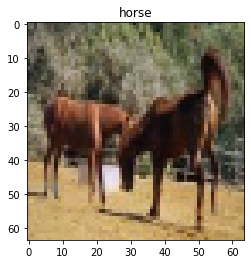

In [81]:
show_image(10, train)

# Preprocessing

In [82]:
new_thing = type(train["data"])
print(new_thing)
print('shape of one data point')
print(train["data"][0].shape)
print(len(train["data"][0]))
print(train["data"].shape)
#64 x 64 x 3 size array is same shape as 3 color channels from 0-4096

print('one array value')
print(train["data"][0][400])

<class 'numpy.ndarray'>
shape of one data point
(12288,)
12288
(10000, 12288)
one array value
99


In [83]:
#creates a (64, 64, 3) inout array for CNN
def input_cell(idx, train, label2name=label2name):
    img = train["data"][idx]
    img = np.dstack((img[:4096], img[4096:8192], img[8192:])).reshape(64,64,3)
    return img

In [84]:
new_thing_2 = input_cell(5, train)
print(new_thing_2.shape)

print('label value at index[0]')
print(train["label"][5])



y_hot = tf.keras.utils.to_categorical(train["label"])

print(type(y_hot))

(64, 64, 3)
label value at index[0]
4
<class 'numpy.ndarray'>


In [85]:
reshape_list = []
#DO IMAGE AUGMENTATION BEFORE THIS LINE!!!!
train_len = len(train["data"])
#converting train data to array of (10000, 64, 64, 3)
print(train_len)
for i in range(train_len):
  tmp = input_cell(i, train)
  tmp.astype('float32')
  reshape_list.append(tmp)

reshape_array = np.array(reshape_list)

print(reshape_array.shape)
print(reshape_array[0].shape)

10000
(10000, 64, 64, 3)
(64, 64, 3)


In [86]:
reshape_train_normal = (reshape_array / 255)

In [87]:
one_array = np.array(train["data"])
one_array_normal = one_array / 255

In [88]:

y_train = np.asarray(train["label"])
values = np.unique(y_train)
number_labels = len(values)
#print(values)
#print(number_labels)

regular_count_y = []

for i in range(len(y_train)):
  regular_count_y.append(y_train[i]-1)

regular_count_y_array = np.asarray(regular_count_y)



y_train_hot = tf.keras.utils.to_categorical(regular_count_y_array, num_classes=10)
print(y_train_hot.shape)
print(y_train_hot)

(10000, 10)
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [89]:
reshape_train_normal.shape

(10000, 64, 64, 3)

# Attempt 1

In [90]:
from keras.optimizers import Adagrad

learning_rate = 0.01
epochs = 4000
#opt = tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9)
opt = Adagrad()
weight_ceiling = 1

In [91]:
cnn = models.Sequential([
    layers.Conv2D(16, 7, activation="relu",input_shape=[64, 64, 3],kernel_initializer='he_normal', kernel_constraint=max_norm(weight_ceiling), bias_constraint=max_norm(weight_ceiling)),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 3, activation="relu",kernel_initializer='he_normal', kernel_constraint=max_norm(weight_ceiling), bias_constraint=max_norm(weight_ceiling)),
    layers.MaxPooling2D(2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

In [92]:
cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [93]:
cnn_history=cnn.fit(reshape_train_normal, y_train_hot, epochs=100,validation_split=0.25)

Epoch 1/100
235/235 [==============================] - 13s 51ms/step - loss: 2.3144 - accuracy: 0.1149 - val_loss: 2.2668 - val_accuracy: 0.1276
Epoch 2/100
235/235 [==============================] - 12s 51ms/step - loss: 2.2666 - accuracy: 0.1347 - val_loss: 2.2510 - val_accuracy: 0.1540
Epoch 3/100
235/235 [==============================] - 12s 52ms/step - loss: 2.2507 - accuracy: 0.1378 - val_loss: 2.2149 - val_accuracy: 0.1404
Epoch 4/100
235/235 [==============================] - 13s 53ms/step - loss: 2.1895 - accuracy: 0.1720 - val_loss: 2.0451 - val_accuracy: 0.2908
Epoch 5/100
235/235 [==============================] - 13s 54ms/step - loss: 2.0922 - accuracy: 0.2499 - val_loss: 2.0044 - val_accuracy: 0.3028
Epoch 6/100
235/235 [==============================] - 13s 56ms/step - loss: 2.0487 - accuracy: 0.2586 - val_loss: 1.9479 - val_accuracy: 0.3160
Epoch 7/100
235/235 [==============================] - 13s 54ms/step - loss: 2.0145 - accuracy: 0.2595 - val_loss: 1.9395 - val_ac

235/235 [==============================] - 13s 56ms/step - loss: 0.9519 - accuracy: 0.6453 - val_loss: 2.1060 - val_accuracy: 0.4312
Epoch 58/100
235/235 [==============================] - 13s 55ms/step - loss: 0.9755 - accuracy: 0.6367 - val_loss: 2.0979 - val_accuracy: 0.4564
Epoch 59/100
235/235 [==============================] - 13s 55ms/step - loss: 0.9717 - accuracy: 0.6454 - val_loss: 2.0584 - val_accuracy: 0.4544
Epoch 60/100
235/235 [==============================] - 13s 54ms/step - loss: 0.9274 - accuracy: 0.6615 - val_loss: 2.1277 - val_accuracy: 0.4444
Epoch 61/100
235/235 [==============================] - 13s 56ms/step - loss: 0.9433 - accuracy: 0.6552 - val_loss: 2.1188 - val_accuracy: 0.4436
Epoch 62/100
235/235 [==============================] - 13s 56ms/step - loss: 0.9242 - accuracy: 0.6675 - val_loss: 2.1708 - val_accuracy: 0.4484
Epoch 63/100
235/235 [==============================] - 14s 58ms/step - loss: 0.9242 - accuracy: 0.6550 - val_loss: 2.1489 - val_accuracy

In [94]:
test = unpickle("test.pkl")
test_data = np.array(test["data"])

In [95]:
b = test_data.copy()
print(b.shape)
reshape_test_data = np.reshape(b, (-1, 64, 64, 3))
print(reshape_test_data.shape)

(2000, 12288)
(2000, 64, 64, 3)


In [96]:
#normalize and change to float 32 for training
normal_test_reshape = reshape_test_data / 255
normal_test_reshape.astype('float32')
print(normal_test_reshape.shape)
#print(normal_test_reshape[0])

(2000, 64, 64, 3)


In [97]:
test_image_val = 301

In [98]:
y_pred = cnn.predict(normal_test_reshape)
print(y_pred[test_image_val])
zero_max_index = np.argmax(y_pred[test_image_val]) + 1
print(zero_max_index)

[1.3597388e-02 1.2946068e-01 1.0327698e-05 4.1780297e-02 4.7115274e-05
 8.1048161e-01 9.7333448e-04 3.3350876e-03 2.2618115e-04 8.7907327e-05]
6


In [99]:
def show_test_image(idx, test):
    img = test["data"][idx]
    img = np.dstack((img[:4096], img[4096:8192], img[8192:])).reshape(64,64,3)
    plt.imshow(img)
    plt.show()

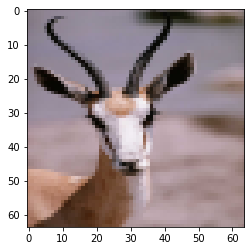

In [100]:
show_test_image(test_image_val, test)

In [101]:
test_len = len(test["data"])
data_list = []
for i in range(test_len):
  max_index = np.argmax(y_pred[i]) + 1
  tmp_tuple = (i, max_index)
  data_list.append(tmp_tuple)

df = pd.DataFrame(data_list, columns =['id', 'label'])
print(df)

        id  label
0        0      4
1        1      1
2        2      8
3        3      2
4        4     10
...    ...    ...
1995  1995      6
1996  1996      9
1997  1997      9
1998  1998      8
1999  1999      8

[2000 rows x 2 columns]


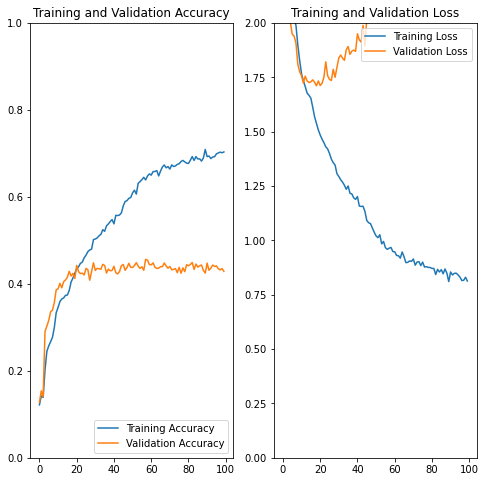

In [112]:
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']

loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs_range = range(0,100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim(0,2)
plt.title('Training and Validation Loss')
plt.show()

# Attempt 2

In [109]:
CNN_book_model = keras.models.Sequential([
    keras.layers.Conv2D(16, 7, activation="relu",input_shape=[64, 64, 3],kernel_initializer='he_normal', kernel_constraint=max_norm(weight_ceiling), bias_constraint=max_norm(weight_ceiling)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(32, 3, activation="relu",kernel_initializer='he_normal', kernel_constraint=max_norm(weight_ceiling), bias_constraint=max_norm(weight_ceiling)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.4),
    #keras.layers.Conv2D(64, 3, activation="relu",kernel_initializer='he_normal', kernel_constraint=max_norm(weight_ceiling), bias_constraint=max_norm(weight_ceiling)),
    #keras.layers.MaxPooling2D(2),
    #keras.layers.Dropout(0.4),
    keras.layers.Flatten(input_shape=[64, 64, 3]),
    keras.layers.Dense(32, activation="relu", kernel_initializer='he_normal', kernel_constraint=max_norm(weight_ceiling), bias_constraint=max_norm(weight_ceiling)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation="softmax", kernel_initializer='he_normal', kernel_constraint=max_norm(weight_ceiling), bias_constraint=max_norm(weight_ceiling))                                
])

In [110]:
 CNN_book_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [125]:
CNN_book_history = CNN_book_model.fit(reshape_train_normal, y_train_hot, epochs=100, validation_split = 0.2)

Epoch 1/100
250/250 [==============================] - 12s 47ms/step - loss: 1.6378 - accuracy: 0.4376 - val_loss: 1.6575 - val_accuracy: 0.4570
Epoch 2/100
250/250 [==============================] - 12s 48ms/step - loss: 1.6416 - accuracy: 0.4369 - val_loss: 1.6586 - val_accuracy: 0.4540
Epoch 3/100
250/250 [==============================] - 12s 49ms/step - loss: 1.6470 - accuracy: 0.4334 - val_loss: 1.6585 - val_accuracy: 0.4555
Epoch 4/100
250/250 [==============================] - 13s 53ms/step - loss: 1.6418 - accuracy: 0.4370 - val_loss: 1.6591 - val_accuracy: 0.4545
Epoch 5/100
250/250 [==============================] - 13s 53ms/step - loss: 1.6460 - accuracy: 0.4251 - val_loss: 1.6564 - val_accuracy: 0.4570
Epoch 6/100
250/250 [==============================] - 14s 54ms/step - loss: 1.6394 - accuracy: 0.4347 - val_loss: 1.6533 - val_accuracy: 0.4540
Epoch 7/100
250/250 [==============================] - 15s 59ms/step - loss: 1.6310 - accuracy: 0.4374 - val_loss: 1.6508 - val_ac

250/250 [==============================] - 15s 60ms/step - loss: 1.5749 - accuracy: 0.4597 - val_loss: 1.6131 - val_accuracy: 0.4665
Epoch 58/100
250/250 [==============================] - 15s 59ms/step - loss: 1.5842 - accuracy: 0.4593 - val_loss: 1.6131 - val_accuracy: 0.4665
Epoch 59/100
250/250 [==============================] - 16s 63ms/step - loss: 1.5658 - accuracy: 0.4696 - val_loss: 1.6129 - val_accuracy: 0.4665
Epoch 60/100
250/250 [==============================] - 15s 59ms/step - loss: 1.5718 - accuracy: 0.4644 - val_loss: 1.6088 - val_accuracy: 0.4710
Epoch 61/100
250/250 [==============================] - 15s 59ms/step - loss: 1.5650 - accuracy: 0.4620 - val_loss: 1.6120 - val_accuracy: 0.4680
Epoch 62/100
250/250 [==============================] - 15s 59ms/step - loss: 1.5766 - accuracy: 0.4569 - val_loss: 1.6116 - val_accuracy: 0.4645
Epoch 63/100
250/250 [==============================] - 15s 59ms/step - loss: 1.5622 - accuracy: 0.4622 - val_loss: 1.6092 - val_accuracy

In [126]:
test = unpickle("test.pkl")
test_data = np.array(test["data"])

In [127]:
b = test_data.copy()
print(b.shape)
reshape_test_data = np.reshape(b, (-1, 64, 64, 3))
print(reshape_test_data.shape)

(2000, 12288)
(2000, 64, 64, 3)


In [128]:
#normalize and change to float 32 for training
normal_test_reshape = reshape_test_data / 255
normal_test_reshape.astype('float32')
print(normal_test_reshape.shape)
#print(normal_test_reshape[0])

(2000, 64, 64, 3)


In [129]:
test_image_val = 301

In [130]:
y_pred = cnn.predict(normal_test_reshape)
print(y_pred[test_image_val])
zero_max_index = np.argmax(y_pred[test_image_val]) + 1
print(zero_max_index)

[1.3597388e-02 1.2946068e-01 1.0327698e-05 4.1780297e-02 4.7115274e-05
 8.1048161e-01 9.7333448e-04 3.3350876e-03 2.2618115e-04 8.7907327e-05]
6


In [131]:
def show_test_image(idx, test):
    img = test["data"][idx]
    img = np.dstack((img[:4096], img[4096:8192], img[8192:])).reshape(64,64,3)
    plt.imshow(img)
    plt.show()

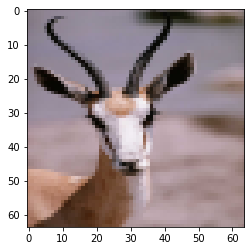

In [132]:
show_test_image(test_image_val, test)

In [133]:
test_len = len(test["data"])
data_list = []
for i in range(test_len):
  max_index = np.argmax(y_pred[i]) + 1
  tmp_tuple = (i, max_index)
  data_list.append(tmp_tuple)

df = pd.DataFrame(data_list, columns =['id', 'label'])
print(df)

        id  label
0        0      4
1        1      1
2        2      8
3        3      2
4        4     10
...    ...    ...
1995  1995      6
1996  1996      9
1997  1997      9
1998  1998      8
1999  1999      8

[2000 rows x 2 columns]


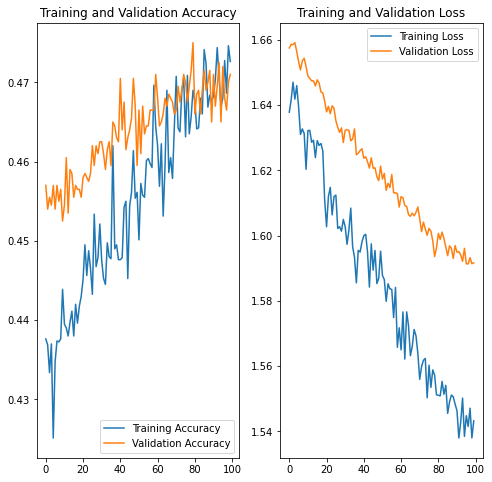

In [137]:
acc = CNN_book_history.history['accuracy']
val_acc = CNN_book_history.history['val_accuracy']

loss = CNN_book_history.history['loss']
val_loss = CNN_book_history.history['val_loss']

epochs_range = range(0,100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Attempt 3

In [138]:
batch_size = 16
nb_classes =4
nb_epochs = 10
img_rows, img_columns = 200, 200
img_channel = 3
nb_filters = 32
nb_pool = 2
nb_conv = 3


In [139]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(64,64 , 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

In [140]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['Accuracy'])

In [141]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshape_train_normal,y_train_hot, test_size=0.33, random_state=42)
X_train[0].shape
y_train.shape

(6700, 10)

In [142]:
model_history=model.fit(X_train, y_train, batch_size=batch_size,epochs = nb_epochs, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/10
419/419 [==============================] - 16s 37ms/step - loss: 2.1560 - accuracy: 0.0000e+00 - val_loss: 1.6820 - val_accuracy: 0.0000e+00
Epoch 2/10
419/419 [==============================] - 15s 35ms/step - loss: 1.5960 - accuracy: 0.0000e+00 - val_loss: 1.5298 - val_accuracy: 0.0000e+00
Epoch 3/10
419/419 [==============================] - 14s 35ms/step - loss: 1.3938 - accuracy: 0.0000e+00 - val_loss: 1.4012 - val_accuracy: 0.0000e+00
Epoch 4/10
419/419 [==============================] - 15s 35ms/step - loss: 1.2152 - accuracy: 0.0000e+00 - val_loss: 1.3963 - val_accuracy: 0.0000e+00
Epoch 5/10
419/419 [==============================] - 15s 36ms/step - loss: 1.0180 - accuracy: 0.0000e+00 - val_loss: 1.3959 - val_accuracy: 0.0000e+00
Epoch 6/10
419/419 [==============================] - 15s 35ms/step - loss: 0.9410 - accuracy: 0.0000e+00 - val_loss: 1.4279 - val_accuracy: 0.0000e+00
Epoch 7/10
419/419 [==============================] - 15s 35ms/step - loss: 0.7897 - acc

In [143]:
test = unpickle("test.pkl")
test_data = np.array(test["data"])

In [144]:
b = test_data.copy()
print(b.shape)
reshape_test_data = np.reshape(b, (-1, 64, 64, 3))
print(reshape_test_data.shape)

(2000, 12288)
(2000, 64, 64, 3)


In [145]:
#normalize and change to float 32 for training
normal_test_reshape = reshape_test_data / 255
normal_test_reshape.astype('float32')
print(normal_test_reshape.shape)
#print(normal_test_reshape[0])

(2000, 64, 64, 3)


In [146]:
test_image_val = 301

In [147]:
y_pred = cnn.predict(normal_test_reshape)
print(y_pred[test_image_val])
zero_max_index = np.argmax(y_pred[test_image_val]) + 1
print(zero_max_index)

[1.3597388e-02 1.2946068e-01 1.0327698e-05 4.1780297e-02 4.7115274e-05
 8.1048161e-01 9.7333448e-04 3.3350876e-03 2.2618115e-04 8.7907327e-05]
6


In [148]:
def show_test_image(idx, test):
    img = test["data"][idx]
    img = np.dstack((img[:4096], img[4096:8192], img[8192:])).reshape(64,64,3)
    plt.imshow(img)
    plt.show()

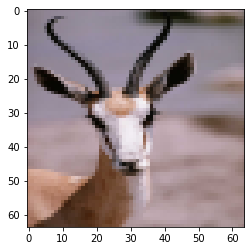

In [149]:
show_test_image(test_image_val, test)

In [150]:
test_len = len(test["data"])
data_list = []
for i in range(test_len):
  max_index = np.argmax(y_pred[i]) + 1
  tmp_tuple = (i, max_index)
  data_list.append(tmp_tuple)

df = pd.DataFrame(data_list, columns =['id', 'label'])
print(df)

        id  label
0        0      4
1        1      1
2        2      8
3        3      2
4        4     10
...    ...    ...
1995  1995      6
1996  1996      9
1997  1997      9
1998  1998      8
1999  1999      8

[2000 rows x 2 columns]


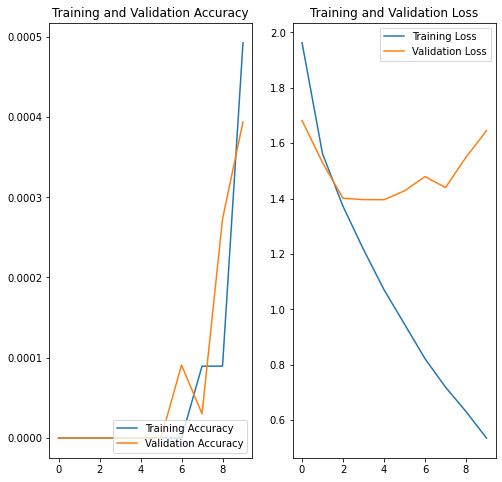

In [151]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(0,10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()